# **Predicting ICU Mortality Using Time-Series Data**

## **Introduction**
This notebook explores the development of predictive models for in-hospital mortality using ICU patient data from the **PhysioNet/CinC Challenge 2012**. The primary goal is to build a patient-specific prediction model based on clinical measurements collected during the first 48 hours of an ICU stay. Accurate mortality predictions can help assess treatment efficacy and improve patient care.

## **Dataset Overview**
The dataset contains records from **4,000 ICU stays**, with **42 clinical variables** recorded at varying frequencies. It includes demographic information, vital signs, laboratory results, and mechanical ventilation status. 

## **Objectives**
- Perform **exploratory data analysis (EDA)** to understand trends and missing data.
- Engineer relevant features and handle missing values.
- Develop **machine learning models** for mortality prediction.
- Evaluate models using appropriate performance metrics.

This notebook will guide through data preprocessing, feature engineering, and model development to predict patient survival outcomes in an ICU setting.


Before diving into the implementation, let's first **import the necessary libraries**. To streamline the workflow, I have encapsulated key functionalities into separate classes, each handling a specific aspect of the pipeline. Below is an overview of these components:

---

### 📂 **File Structure & Functionalities**  

#### 🛠 **`pre_processor.py`** – Data Extraction & Preprocessing  
- This module handles **data extraction** and **feature engineering**.  
- It leverages **multiprocessing** to efficiently compile a **master dataset** in `.csv` format along with individual `.json` files for each patient.  
- The **time-series features** are processed, extracting key characteristics such as:  
  - **Mean, Median, Minimum, Maximum, Slope, First Value, and Last Value**.

---

#### 🔄 **`imputer.py`** – Data Imputation  
- This class generates **four different imputed datasets** using the following methods:  
  1. **Mean Imputation**  
  2. **Median Imputation**  
  3. **K-Nearest Neighbors (KNN) Imputation**  
  4. **Iterative Imputation (Multivariate Approach)**  

---

#### 🤖 **`model_evaluator_adjusted.py`** – Machine Learning Pipeline  
- This module serves as the **core ML model evaluator**.  
- It takes the **final imputed datasets** and trains multiple **machine learning models**.  
- The script evaluates models based on key performance **metrics** and prints out **detailed results**.  

---

With this modular structure, we ensure **scalability, efficiency, and clarity** in our workflow. 🚀 Now, let's proceed with the implementation!




In [2]:
# Encapsulated some of the pipeline steps into a single classes
from pre_processor import PatientDataProcessor
from impute_processor import Imputer
from model_evaluator_adjusted import MortalityModelEvaluatorAdjusted, FeatureImportanceVisualizer

# Importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

# Improving the display of the markdown! I may have gone over board with it though! :D
from IPython.display import display, Markdown

The `seta_data.csv` file is a comprehensive dataset containing all possible entries. We process this data to create a master table named `patients_master_table.csv`. Below, we load this master table and visualize the percentage of missing values in columns containing "_mean".

---

### 📂 **Master Patient Data Overview**

- **File Path:** `data/patients_master_table.csv`
- **Individual Patient Summury:** Also this will create all the `.json` files in `data/patient_jsons` directory.

In [2]:
# This script is used to process patient data in parallel.
path_to_features = "data/seta_data.csv"
path_to_outcomes = "data/Outcomes-a.txt"

# Initialize the PatientDataProcessor with the paths to the data files
processor = PatientDataProcessor(path_to_features, path_to_outcomes)
processor.print_summary()
processor.process_patients_parallel()

2025-03-05 17:11:41,847 - INFO - Loading dataset...
2025-03-05 17:11:42,296 - INFO - Identified 36 time-series parameters.
2025-03-05 17:11:42,297 - INFO - Generating summary of dataset...
2025-03-05 17:11:44,313 - INFO - Summary of Time-Series Features:
2025-03-05 17:11:44,314 - INFO - GCS: Present in 98.40% of patients
2025-03-05 17:11:44,315 - INFO - HR: Present in 98.42% of patients
2025-03-05 17:11:44,316 - INFO - NIDiasABP: Present in 87.08% of patients
2025-03-05 17:11:44,317 - INFO - NIMAP: Present in 87.02% of patients
2025-03-05 17:11:44,317 - INFO - NISysABP: Present in 87.33% of patients
2025-03-05 17:11:44,318 - INFO - RespRate: Present in 27.52% of patients
2025-03-05 17:11:44,318 - INFO - Temp: Present in 98.40% of patients
2025-03-05 17:11:44,319 - INFO - Urine: Present in 97.08% of patients
2025-03-05 17:11:44,319 - INFO - HCT: Present in 98.40% of patients
2025-03-05 17:11:44,320 - INFO - BUN: Present in 98.40% of patients
2025-03-05 17:11:44,320 - INFO - Creatinine: 

### 📌 First 5 Rows of `patients_master_table.csv`

,patient_id,age,gender,height,weight,icutype,gcs_mean,gcs_median,gcs_slope,gcs_min_value,...,troponint_slope,troponint_min_value,troponint_max_value,troponint_first_value,troponint_last_value,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,54.0,0.0,-1.0,-1.0,4.0,15.000000,15.0,NaN,15.0,...,NaN,NaN,NaN,NaN,NaN,6,1,5,-1,0
1,132540,76.0,1.0,175.3,76.0,2.0,14.666667,15.0,-0.069930,13.0,...,NaN,NaN,NaN,NaN,NaN,16,8,8,-1,0
2,132541,44.0,0.0,-1.0,56.7,3.0,5.923077,5.0,-0.252747,5.0,...,NaN,NaN,NaN,NaN,NaN,21,11,19,-1,0
3,132543,68.0,1.0,180.3,84.6,3.0,15.000000,15.0,NaN,15.0,...,NaN,NaN,NaN,NaN,NaN,7,1,9,575,0
4,132545,88.0,0.0,-1.0,-1.0,3.0,15.000000,15.0,NaN,15.0,...,NaN,NaN,NaN,NaN,NaN,17,2,4,918,0


/tmp/ipykernel_1291008/1503295157.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette="coolwarm")
/home/samanseifi/miniforge3/envs/vertex/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


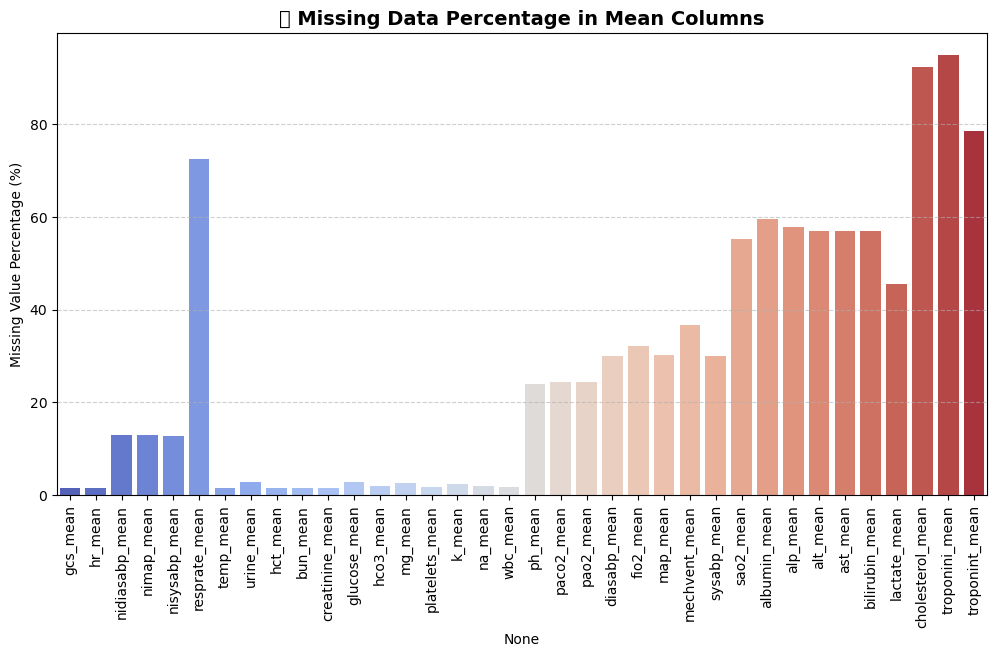

In [2]:
# 🎯 Load the Master Patient Data
file_path = "data/patients_master_table.csv"
master_data_table = pd.read_csv(file_path)

# 📝 Display the first 5 rows of the dataset
display(Markdown("### 📌 First 5 Rows of `patients_master_table.csv`"))
display(master_data_table.head())

# 🔍 Identify columns containing "_mean"
mean_columns = [col for col in master_data_table.columns if "_mean" in col]
min_columns = [col for col in master_data_table.columns if "_min" in col]
max_columns = [col for col in master_data_table.columns if "_max" in col]
median_columns = [col for col in master_data_table.columns if "_median" in col]

# 📊 Calculate the percentage of missing values in the mean columns
missing_percentage = master_data_table[mean_columns].isnull().mean() * 100

# 🎨 Plot missing values with a sleek visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel("Missing Value Percentage (%)")
plt.title("🩺 Missing Data Percentage in Mean Columns", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# 🔹 Show the visualization
plt.show()


## Feature Engineering Steps

### 🔢 Constants & Their Roles  

Before proceeding with data processing, we define key constants that will guide various preprocessing steps:  

- **📂 File Path:**  
  - `FILE_PATH = "data/patients_master_table.csv"`  
  - Specifies the location of the **master dataset**.   

- **⚠️ Outlier Detection:**  
  - `OUTLIER_THRESHOLD = 3`  
  - Uses a **Z-score threshold** of **3** to identify and handle **outliers**.  

- **🔍 Handling Missing Values:**  
  - `MISSING_VALUE_THRESHOLD_REMOVE = 60`  
  - Columns with **more than 60% missing values** will be **removed**.  

- **📉 Feature Selection – Low Variance:**  
  - `LOW_VARIANCE_THRESHOLD = 0.05`  
  - Features with a **variance below 0.05** will be **dropped** due to low predictive power.  

- **📊 Feature Selection – High Correlation:**  
  - `HIGH_CORRELATION_THRESHOLD = 0.95`  
  - Features with a **correlation above 0.95** will be **removed** to prevent redundancy.  

---

These constants will be applied in the **next steps** for **data cleaning, feature engineering, and model preparation**. 🚀  


In [3]:
# Constants
FILE_PATH = "data/patients_master_table.csv"
OUTLIER_THRESHOLD = 3  # Z-score threshold for outlier detection
MISSING_VALUE_THRESHOLD_REMOVE = 60  # % threshold for removing columns
LOW_VARIANCE_THRESHOLD = 0.05  # Variance threshold for feature selection
HIGH_CORRELATION_THRESHOLD = 0.95  # Threshold for dropping highly correlated features

In [4]:
data = pd.read_csv(FILE_PATH)
print(f"✅ Loaded dataset with {data.shape[0]} rows and {data.shape[1]} columns.")

✅ Loaded dataset with 4000 rows and 263 columns.


### 🛠 Step 1: Handling Missing & Incorrect Values  

In this step, we clean the dataset by fixing **invalid values** and handling **outliers**.  

#### ✅ Fixing Invalid Values:  
- Some columns (**age, height, weight**) contain **invalid values like `-1`**, which likely represent missing data.  
- These values are replaced with **NaN (missing values)** for proper handling (Imputation) later.  

#### 🔍 Removing Outliers:  
To ensure data consistency, we define **reasonable value ranges** for numeric variables:  
- **Age:** Between **0 and 120 years**  
- **Height:** Between **50 cm and 250 cm**  
- **Weight:** Between **30 kg and 200 kg**  

Any values **outside these ranges** are considered **outliers** and replaced with **NaN**.  


In [5]:
#  Handle Missing or Erroneous Values
def clean_data(df):
    """Replace invalid values with NaN and handle outliers."""
    cols_to_clean = ["age", "height", "weight"]
    
    # Replace -1 values with NaN
    df[cols_to_clean] = df[cols_to_clean].replace(-1, np.nan)

    # Define reasonable ranges for numeric variables
    valid_ranges = {
        "age": (0, 120),
        "height": (50, 250),
        "weight": (30, 200),
    }

    # Apply range-based filtering to replace outliers with NaN
    for col, (min_val, max_val) in valid_ranges.items():
        df[col] = df[col].mask((df[col] < min_val) | (df[col] > max_val), np.nan)

    return df

data = clean_data(data)


### 🗑 Step 2: Dropping Completely Empty Columns  

After handling missing values, some columns might be **entirely empty**.  
- We **remove these columns** from the dataset to keep only useful data.  
- Finally, we print the **remaining number of columns** after cleanup.  


In [6]:
# Drop Completely Empty Columns
data.dropna(axis=1, how="all", inplace=True)
print(f"✅ Dropped empty columns. Remaining: {data.shape[1]} columns.")

✅ Dropped empty columns. Remaining: 262 columns.


### 🛠 Step 3: Handling Missing Values  

In this step, we analyze how many **missing values** each column has and decide whether to keep or remove them.  

#### 📊 Checking Missing Data:  
- We calculate the **percentage of missing values** for each column.  
- If a column has **more than 40% missing values**, we display it in a table to review its impact.  

#### 🗑 Removing Columns with Too Many Missing Values:  
- Columns with **over 60% missing values** are **removed**, as they may not provide useful insights.  
- We retain only the **columns with sufficient data** to improve model performance.  

We can **adjust these thresholds later** to see if it improves our results. 🚀  


In [7]:
missing_percentage = data.isna().mean() * 100

# Display missing values in a readable table (useful for Jupyter Notebooks)
from IPython.display import display
print("📊 Columns with >40% missing values:")
display(missing_percentage[missing_percentage > 40].to_frame(name="Missing %"))

# Drop columns with >60% missing values
data = data.loc[:, missing_percentage < MISSING_VALUE_THRESHOLD_REMOVE]
print(f"✅ Columns retained after filtering missing values: {data.shape[1]}")

📊 Columns with >40% missing values:


,Missing %
height,47.750
gcs_slope,44.675
resprate_mean,72.475
resprate_median,72.475
resprate_slope,72.575
...,...
troponint_slope,86.450
troponint_min_value,78.425
troponint_max_value,78.425
troponint_first_value,78.425


✅ Columns retained after filtering missing values: 226


### 🛠 Step 4: Detecting & Removing Outliers  

Although we already performed **outlier detection and removal** during the data extraction process, we apply an **additional mild outlier filtering** here.  

#### 📊 How It Works:  
- We calculate the **Z-score** for each numerical column to measure how far a value deviates from the mean.  
- Any value **beyond the defined threshold (default: 3)** is considered an **outlier** and replaced with **NaN**.  

This helps ensure **extreme values** do not negatively impact our analysis and model performance. 🚀  


In [8]:
# Step 4: Outlier Detection & Removal
def remove_outliers(df, threshold=OUTLIER_THRESHOLD):
    """Replaces outliers in numerical columns with NaN based on Z-score."""
    num_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std()
    df[num_cols] = df[num_cols].mask(abs(z_scores) > threshold, np.nan)
    return df

data = remove_outliers(data)

### 🏗 Step 5: Removing Low-Variance Features  

Some features in the dataset might have **very little variation** across patients, meaning they provide **minimal useful information** for modeling. To clean the dataset, we **remove features with very low variance**.

#### 🛠 How It Works:  
- We apply **VarianceThreshold** to filter out columns with variance **below 0.05** (default).  
- This step ensures the model focuses on **meaningful features** and removes **redundant or nearly constant columns**.  
- We display the **retained features** after filtering.

🚀 This improves model performance by **reducing noise** and **improving efficiency**!


In [9]:
# Step 5: Outlier Detection & Removal
selector = VarianceThreshold(threshold=LOW_VARIANCE_THRESHOLD)
selector.fit(data.fillna(0))  # Replace NaNs with 0 for variance computation
data = data[data.columns[selector.get_support()]]
print(f"✅ Removed low variance columns. Remaining: {data.shape[1]} columns.")

✅ Removed low variance columns. Remaining: 221 columns.


### 🔗 Step 6: Removing Highly Correlated Features  

When two or more features are **highly correlated**, they provide **redundant information** to the model, which can lead to **overfitting** and reduced generalization. To address this, we remove one of the highly correlated features.

#### 🛠 How It Works:  
- We compute the **correlation matrix** to measure relationships between features.  
- We focus on the **upper triangle** of the matrix to avoid duplicate comparisons.  
- Any feature with a **correlation above 0.95** (default threshold) is **dropped** to reduce redundancy.  

#### ✅ Why This Matters?  
- It **improves model performance** by eliminating unnecessary features.  
- It **prevents multicollinearity**, ensuring the model can interpret feature importance correctly.  

After this step, we print the **remaining number of features** to track progress. 🚀  


In [10]:
# Step 6: Remove Highly Correlated Features
def remove_high_correlation(df, threshold=HIGH_CORRELATION_THRESHOLD):
    """Removes highly correlated features based on correlation matrix."""
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=to_drop)

data = remove_high_correlation(data)
print(f"✅ Removed highly correlated columns. Remaining: {data.shape[1]} columns.")

✅ Removed highly correlated columns. Remaining: 165 columns.


In [11]:
print(f"📌 Final dataset: {data.shape[0]} rows, {data.shape[1]} columns.")

# Display first few rows
display(data.head())


📌 Final dataset: 4000 rows, 165 columns.


,patient_id,age,gender,height,weight,icutype,gcs_mean,gcs_slope,gcs_min_value,gcs_max_value,...,lactate_mean,lactate_min_value,lactate_max_value,lactate_first_value,lactate_last_value,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,54.0,0.0,NaN,NaN,4.0,15.000000,NaN,15.0,15.0,...,NaN,NaN,NaN,NaN,NaN,6.0,1.0,5.0,-1.0,0
1,132540,76.0,1.0,175.3,76.0,2.0,14.666667,-0.069930,13.0,15.0,...,NaN,NaN,NaN,NaN,NaN,16.0,8.0,8.0,-1.0,0
2,132541,44.0,0.0,NaN,56.7,3.0,5.923077,-0.252747,5.0,8.0,...,1.366667,0.9,1.9,1.3,0.9,21.0,11.0,19.0,-1.0,0
3,132543,68.0,1.0,180.3,84.6,3.0,15.000000,NaN,15.0,15.0,...,NaN,NaN,NaN,NaN,NaN,7.0,1.0,9.0,575.0,0
4,132545,88.0,0.0,NaN,NaN,3.0,15.000000,NaN,15.0,15.0,...,NaN,NaN,NaN,NaN,NaN,17.0,2.0,4.0,918.0,0


## Handling Missing Data with Imputation  

When a dataset contains **missing values**, we need to fill them using an **imputation strategy** to ensure models can be trained effectively. This step applies **multiple imputation methods** and saves the results.

#### 🛠 How It Works:  
1. **Identify Numeric Columns**  
   - The imputation process focuses on **numeric features** in the dataset.  

2. **Apply Four Imputation Methods**  
   - **Mean Imputation** – Replaces missing values with the **mean** of the column.  
   - **Median Imputation** – Replaces missing values with the **median** of the column.  
   - **KNN Imputation** – Uses **20 nearest neighbors** to estimate missing values.  
   - **Iterative Imputation** – Uses **machine learning models** to predict missing values based on other features.  

3. **Save the Imputed Datasets**  
   - Each imputed dataset is saved as a **CSV file** for later use.  

#### ✅ Why This Matters?  
- Prevents models from failing due to missing values.  
- Ensures missing data is **filled logically** using different strategies.  
- Provides flexibility to compare different imputation methods.  

After running this step, we get **four different imputed datasets**, ready for further analysis. 🚀  


In [12]:
imputer = Imputer(data)
imputer.process()

Applying imputations...
Saved mean imputed dataset at data/mean_imputed.csv.
Saved median imputed dataset at data/median_imputed.csv.
Saved knn imputed dataset at data/knn_imputed.csv.


/home/samanseifi/miniforge3/envs/vertex/lib/python3.10/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Saved iterative imputed dataset at data/iterative_imputed.csv.
Imputation completed.


### 🚀 Machine Learning Model Evaluation  

In this step, we train and evaluate **multiple machine learning models** to predict **in-hospital mortality** using different imputed datasets.  

#### 🛠 **How It Works**  

1. **📂 Load Imputed Datasets**  
   - Reads previously imputed datasets.  
   - Ensures consistent preprocessing across different methods.  

2. **📊 Data Preparation**  
   - **Feature Selection**: Drops irrelevant columns such as **SAPS-I, SOFA, Length_of_stay, Survival**.  
   - **Train-Test Split**: Splits data into **80% training** and **20% testing**, maintaining class balance.  
   - **Standardization**: Normalizes numeric features to improve model performance.  

3. **🤖 Model Training & Evaluation**  
   - Trains **12 machine learning models**, including:  
     - **Logistic Regression, Random Forest, Gradient Boosting, XGBoost, Neural Networks (MLP), SVM, Naïve Bayes, Decision Tree**, and **more**.  
   - Evaluates each model using:  
     - **Accuracy** → Measures overall correctness.  
     - **Sensitivity (Recall)** → Measures how well the model detects actual positive cases.  
     - **Precision (PPV)** → Measures how many predicted positives are actually correct.  
     - **F1-score** → Balances Sensitivity & Precision.  
     - **Calibration Metrics** → χ² Calibration Statistic & H-Statistic to assess probability reliability.  

4. **📈 Model Ranking & Visualization**  
   - Models are ranked based on **Event-1 performance** (minimum of Sensitivity & Precision).  
   - Generates **performance comparison plots** for different models across imputation methods.  

---

### ✅ **Why This Matters?**  
- **Ensures fair model evaluation** across different imputed datasets.  
- **Identifies the best-performing model** for real-world use.  
- **Improves interpretability** by analyzing probability calibration.  

After this step, we get a **ranked list of models** and their performance metrics, helping us select the most effective approach for mortality prediction. 🚀  


In [4]:
imputed_files = {
    "Mean": "data/mean_imputed.csv",
    "Median": "data/median_imputed.csv",
    "KNN": "data/knn_imputed.csv",
    "Iterative": "data/iterative_imputed.csv"
}

evaluator = MortalityModelEvaluatorAdjusted(imputed_files)
final_adjusted_model = evaluator.run()


Evaluating models using Mean imputed data
Logistic Regression - Accuracy: 0.7600, Sensitivity: 0.7297, Precision: 0.3333, Event-1: 0.3333
Random Forest - Accuracy: 0.8712, Sensitivity: 0.1622, Precision: 0.6429, Event-1: 0.1622
Decision Tree - Accuracy: 0.8013, Sensitivity: 0.5225, Precision: 0.3537, Event-1: 0.3537
Extra Trees - Accuracy: 0.8612, Sensitivity: 0.5225, Precision: 0.5000, Event-1: 0.5000
Gradient Boosting - Accuracy: 0.8800, Sensitivity: 0.2883, Precision: 0.6531, Event-1: 0.2883
SVM - Accuracy: 0.8275, Sensitivity: 0.5946, Precision: 0.4151, Event-1: 0.4151
XGBoost - Accuracy: 0.8888, Sensitivity: 0.4685, Precision: 0.6341, Event-1: 0.4685
Neural Net - Accuracy: 0.8550, Sensitivity: 0.3604, Precision: 0.4706, Event-1: 0.3604

Evaluating models using Median imputed data
Logistic Regression - Accuracy: 0.7612, Sensitivity: 0.7117, Precision: 0.3319, Event-1: 0.3319
Random Forest - Accuracy: 0.8662, Sensitivity: 0.1351, Precision: 0.5769, Event-1: 0.1351
Decision Tree - A

# **Model Performance Ranking & Next Steps**

## **Best Models Based on F1-Score (Balanced Metric)**

| Rank | Model (Imputation)         | Accuracy | Sensitivity (Se) | Precision (PPV) | F1-Score |
|------|----------------------------|----------|------------------|----------------|----------|
| 1️⃣  | **XGBoost (Iterative)**      | **0.880** | 0.496            | **0.579**      | **0.534** |
| 2️⃣  | **SVM (Iterative)**         | 0.832    | **0.649**        | 0.431          | 0.518    |
| 3️⃣  | **Extra Trees (Iterative)** | 0.856    | 0.523            | 0.483          | 0.502    |
| 4️⃣  | **SVM (KNN)**               | 0.825    | 0.631            | 0.414          | 0.500    |
| 5️⃣  | **SVM (Mean)**              | 0.828    | 0.595            | 0.415          | 0.489    |
| 6️⃣  | **Logistic Regression (Iterative)** | 0.778 | **0.757** | 0.357          | 0.486    |

- **XGBoost (Iterative Imputation) achieved the best F1-score, balancing sensitivity and precision.**  
- **SVM (Iterative) performed slightly better in sensitivity, trading off some precision.**  
- **Extra Trees (Iterative) had a solid balance between sensitivity and precision, making it a strong alternative.**  
- **Logistic Regression had the highest sensitivity but lower precision.**  

## **Best Models for High Sensitivity (Detecting Mortality Cases)**
1. **Logistic Regression (Iterative Imputation)** – **Se = 0.757**, F1 = 0.486  
2. **SVM (Iterative Imputation)** – **Se = 0.649**, F1 = 0.518  
3. **Extra Trees (Iterative Imputation)** – **Se = 0.523**, F1 = 0.502  

> **Use these if missing mortality cases is critical.**

## **Best Models for High Precision (Reducing False Positives)**
1. **Extra Trees (Median Imputation)** – **PPV = 1.000**, F1 = 0.165  
2. **Bagging (KNN Imputation)** – **PPV = 0.727**, F1 = 0.333  
3. **Gradient Boosting (Iterative Imputation)** – **PPV = 0.641**, F1 = 0.402  

> **Use these if false alarms are costly.**

---

## **Next Steps**
### **1️⃣ Feature Importance Analysis**
- Use **SHAP values** or built-in feature importance from **XGBoost/Gradient Boosting/Extra Trees**.
- Identify critical features influencing mortality predictions.

### **2️⃣ Hyperparameter Optimization**
- **GridSearchCV / Bayesian Optimization** for **SVM, XGBoost, Extra Trees, and Gradient Boosting**.
- Tune parameters like **C (for SVM), learning rate, max depth, and regularization**.

### **3️⃣ Class Imbalance Handling**
- Use **class weighting** (`class_weight='balanced'` in Scikit-learn).
- Apply **SMOTE (Synthetic Minority Over-sampling Technique)** to balance classes.

### **4️⃣ Model Stacking & Ensembles**
- Combine **SVM + XGBoost + Extra Trees + Gradient Boosting** for better performance.
- Try **stacked generalization** with Logistic Regression as a meta-learner.

### **5️⃣ Deep Learning Approach**
- Implement a **Neural Network (TensorFlow/Keras)**.
- Try **LSTM/GRU for time-series modeling** if sequences matter.



Top 10 Features for Random Forest (Mean Imputation):
['gcs_last_value' 'gcs_mean' 'bun_mean' 'gcs_max_value' 'urine_mean'
 'paco2_mean' 'gcs_slope' 'urine_max_value' 'temp_mean' 'gcs_min_value']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


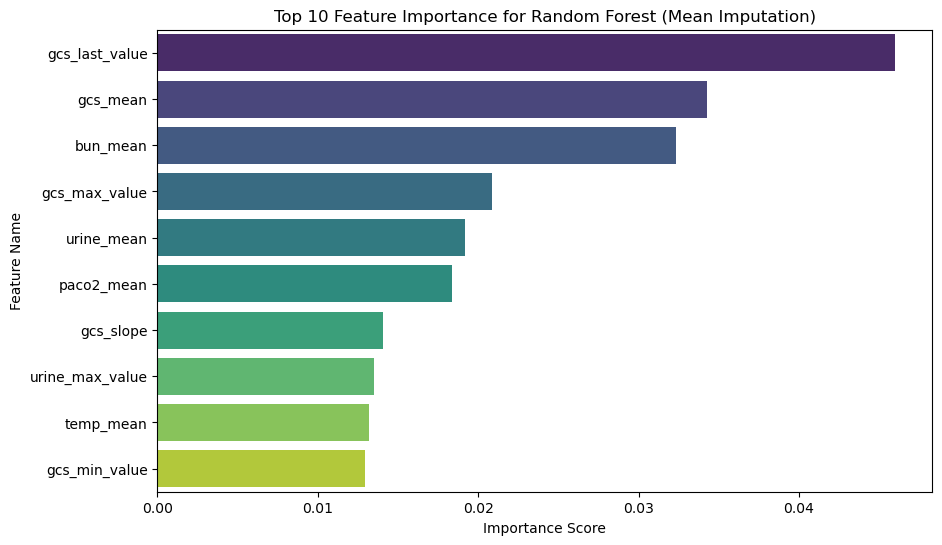


Top 10 Features for Decision Tree (Mean Imputation):
['gcs_last_value' 'bun_mean' 'temp_last_value' 'platelets_mean'
 'pao2_min_value' 'albumin_mean' 'urine_mean' 'hr_last_value'
 'na_min_value' 'icutype']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


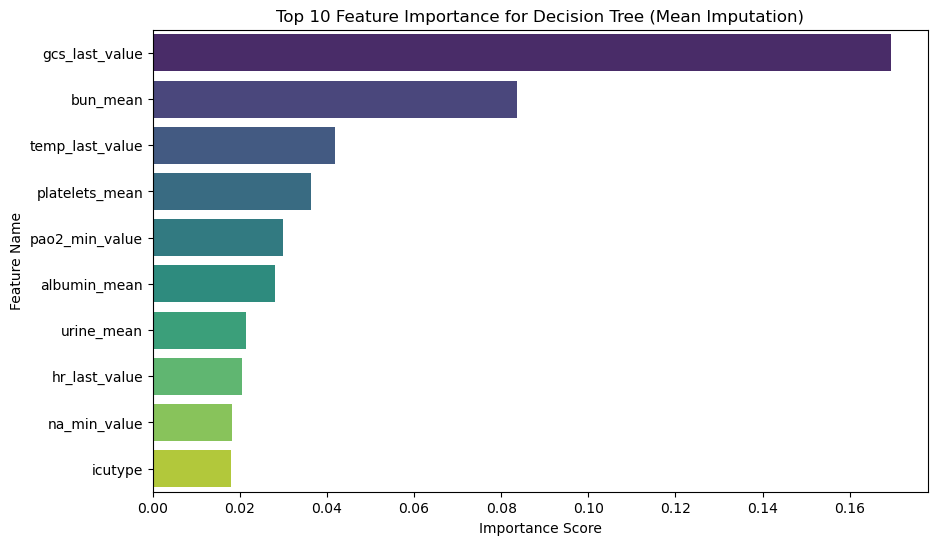


Top 10 Features for Extra Trees (Mean Imputation):
['gcs_last_value' 'gcs_mean' 'gcs_max_value' 'bun_mean' 'gcs_min_value'
 'icutype' 'age' 'gcs_slope' 'urine_mean' 'gcs_first_value']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


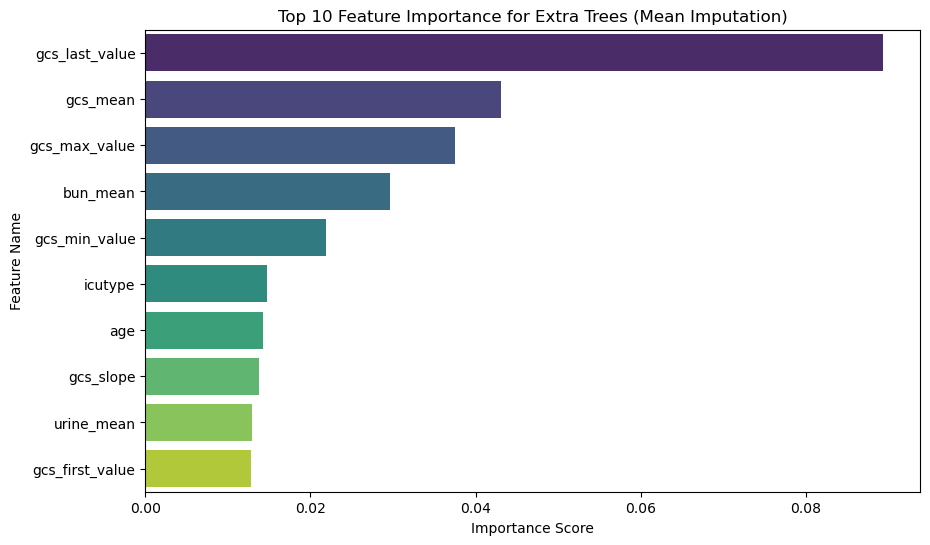


Top 10 Features for Gradient Boosting (Mean Imputation):
['gcs_last_value' 'bun_mean' 'hco3_mean' 'urine_mean' 'age' 'temp_mean'
 'temp_last_value' 'paco2_max_value' 'ph_mean' 'hr_last_value']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


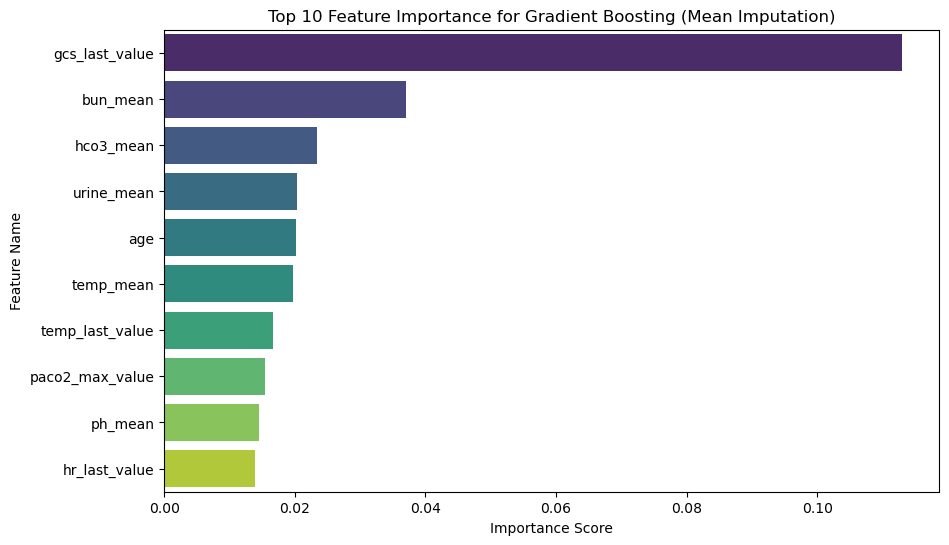


Top 10 Features for XGBoost (Mean Imputation):
['gcs_last_value' 'bun_mean' 'icutype' 'temp_last_value' 'paco2_mean'
 'albumin_mean' 'alp_mean' 'urine_max_value' 'gcs_mean' 'paco2_max_value']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


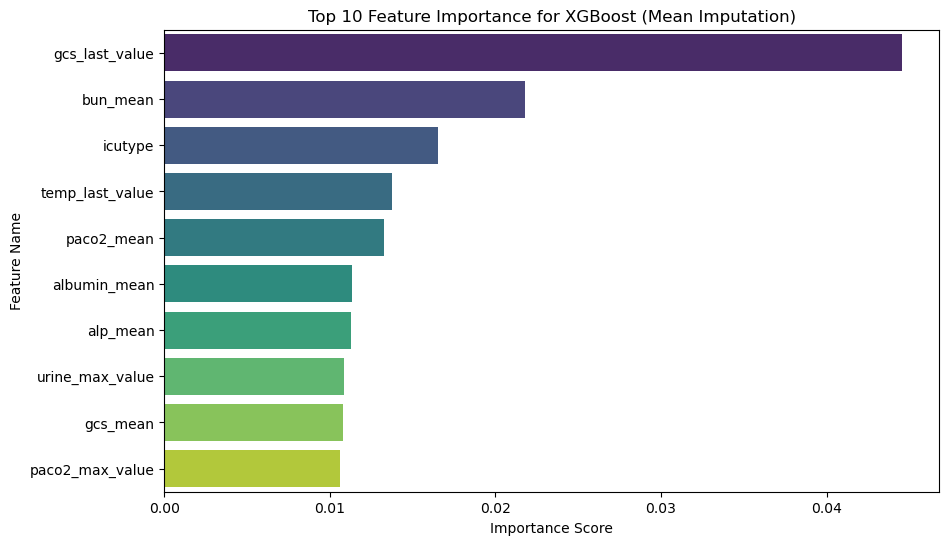


Top 10 Features for Random Forest (Median Imputation):
['gcs_last_value' 'gcs_mean' 'bun_mean' 'urine_mean' 'paco2_mean'
 'gcs_max_value' 'gcs_slope' 'urine_max_value' 'temp_mean'
 'creatinine_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


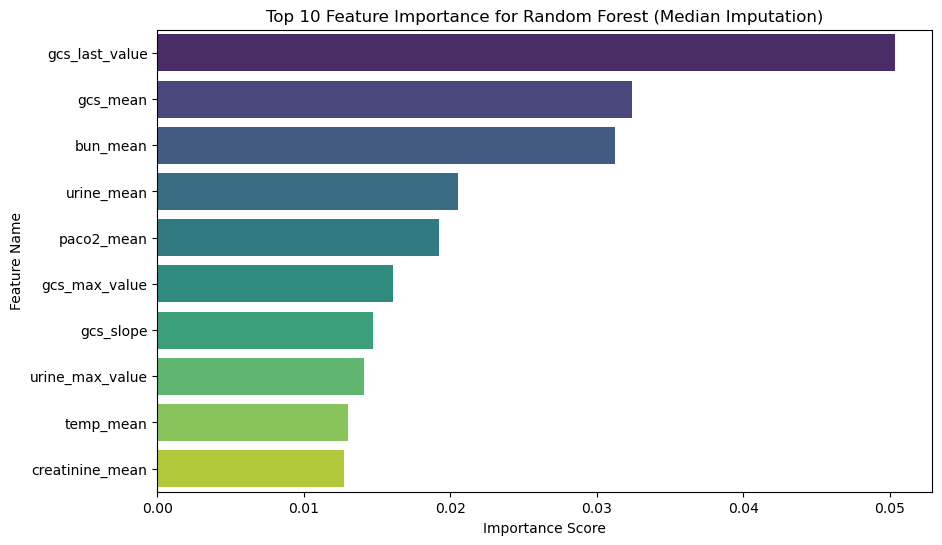


Top 10 Features for Decision Tree (Median Imputation):
['gcs_last_value' 'bun_mean' 'albumin_mean' 'urine_mean' 'temp_last_value'
 'k_slope' 'temp_mean' 'age' 'icutype' 'alp_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


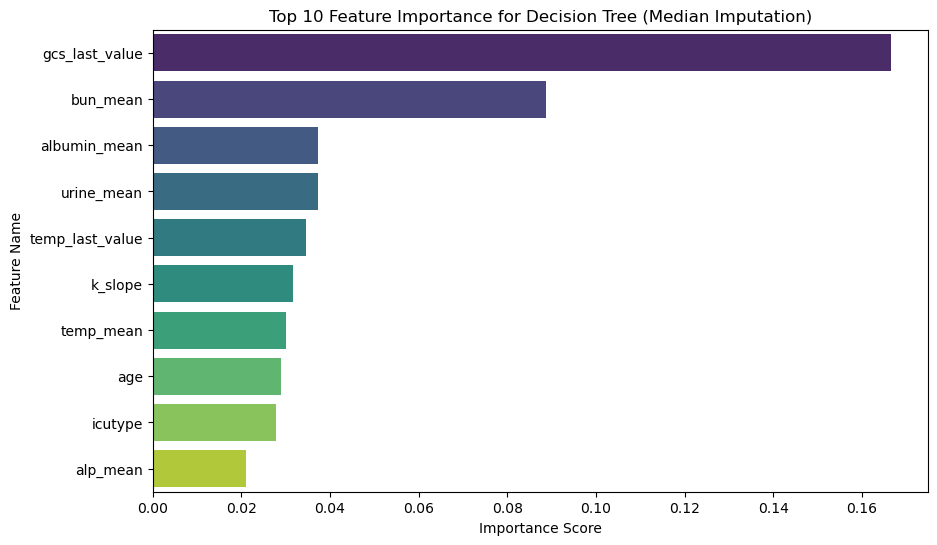


Top 10 Features for Extra Trees (Median Imputation):
['gcs_last_value' 'gcs_mean' 'gcs_max_value' 'bun_mean' 'gcs_min_value'
 'icutype' 'age' 'urine_max_value' 'hco3_mean' 'creatinine_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


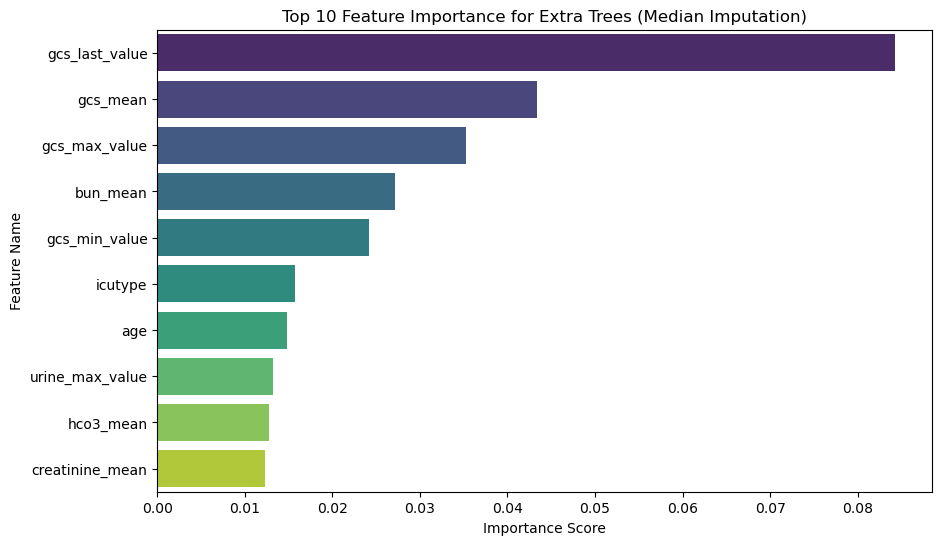


Top 10 Features for Gradient Boosting (Median Imputation):
['gcs_last_value' 'bun_mean' 'hco3_mean' 'age' 'temp_mean' 'ph_mean'
 'temp_last_value' 'urine_mean' 'paco2_max_value' 'alp_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


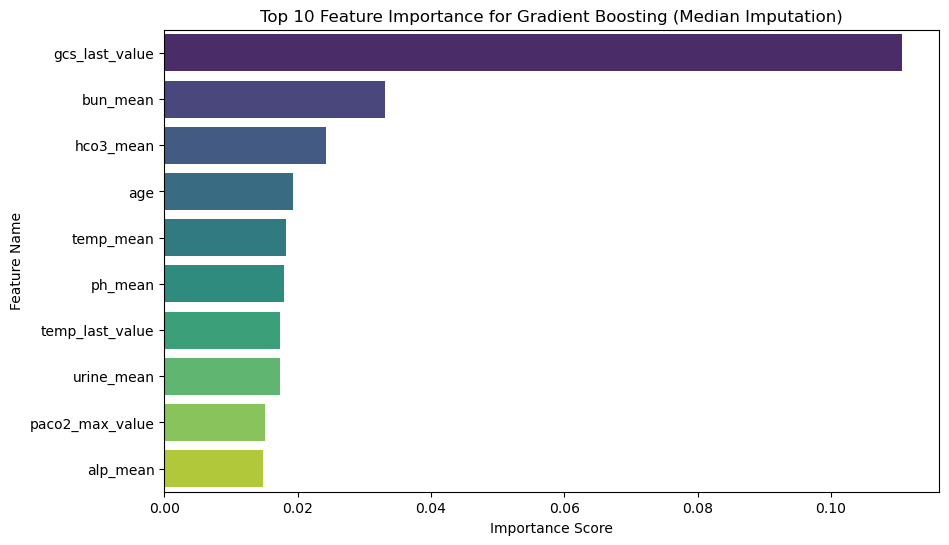


Top 10 Features for XGBoost (Median Imputation):
['gcs_last_value' 'bun_mean' 'icutype' 'paco2_mean' 'alp_mean'
 'temp_last_value' 'urine_max_value' 'gcs_mean' 'albumin_mean'
 'urine_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


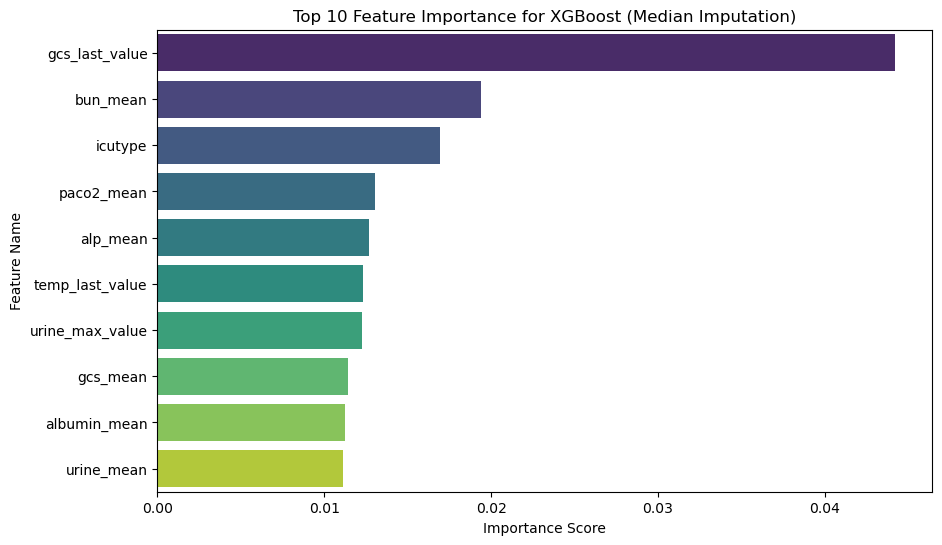


Top 10 Features for Random Forest (KNN Imputation):
['gcs_last_value' 'gcs_mean' 'bun_mean' 'gcs_max_value' 'gcs_slope'
 'urine_mean' 'paco2_mean' 'albumin_mean' 'temp_mean' 'creatinine_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


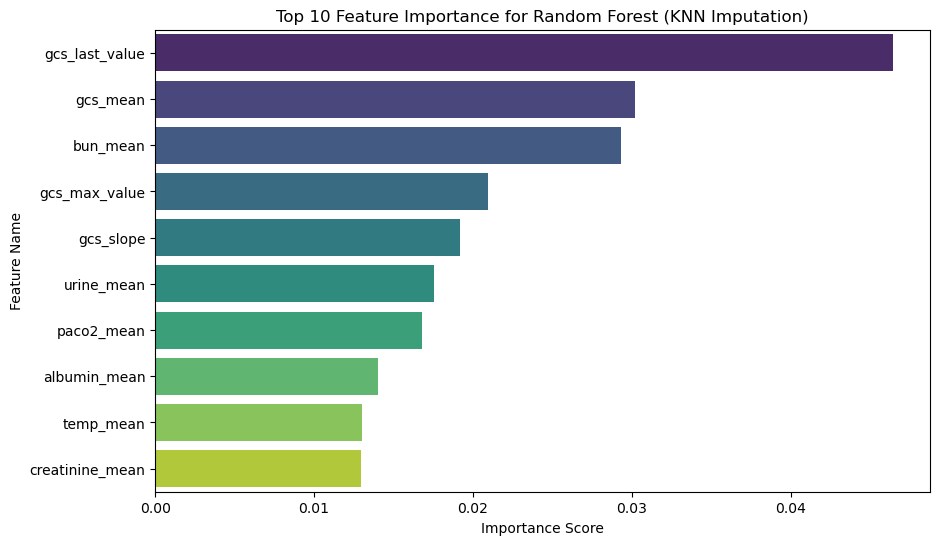


Top 10 Features for Decision Tree (KNN Imputation):
['gcs_last_value' 'bun_mean' 'albumin_mean' 'platelets_mean'
 'temp_last_value' 'icutype' 'sysabp_max_value' 'urine_mean' 'bun_slope'
 'gcs_slope']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


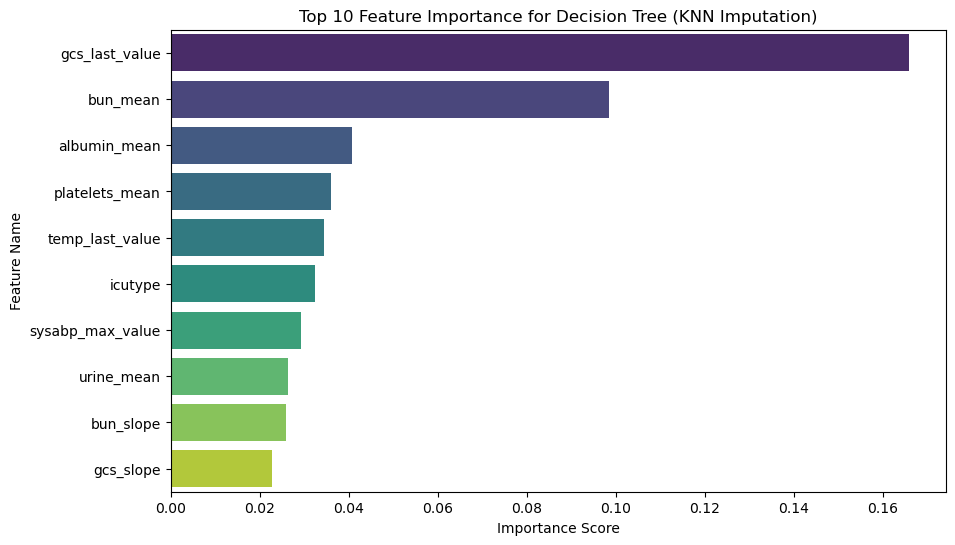


Top 10 Features for Extra Trees (KNN Imputation):
['gcs_last_value' 'gcs_mean' 'gcs_max_value' 'bun_mean' 'gcs_min_value'
 'icutype' 'gcs_slope' 'age' 'urine_mean' 'hco3_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


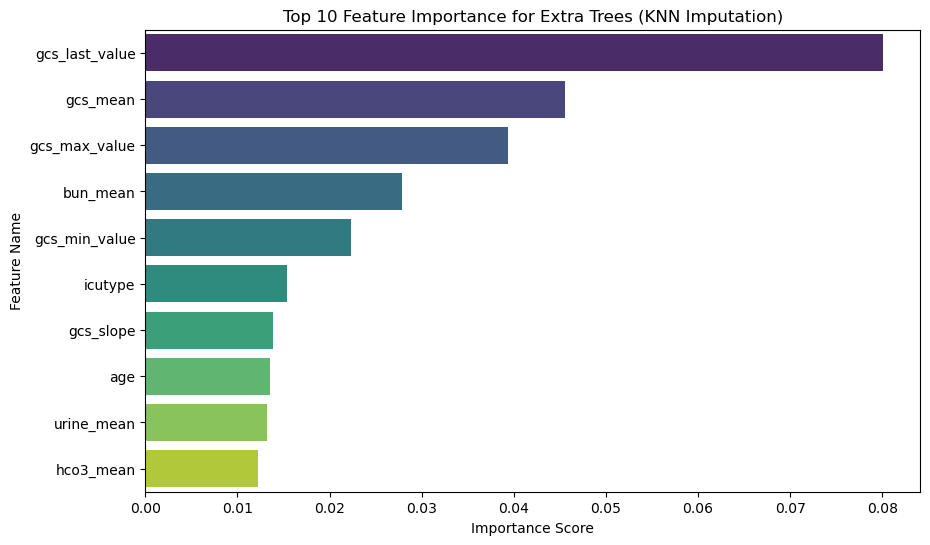


Top 10 Features for Gradient Boosting (KNN Imputation):
['gcs_last_value' 'bun_mean' 'lactate_min_value' 'temp_mean' 'urine_mean'
 'age' 'ph_mean' 'sysabp_max_value' 'hr_slope' 'hco3_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


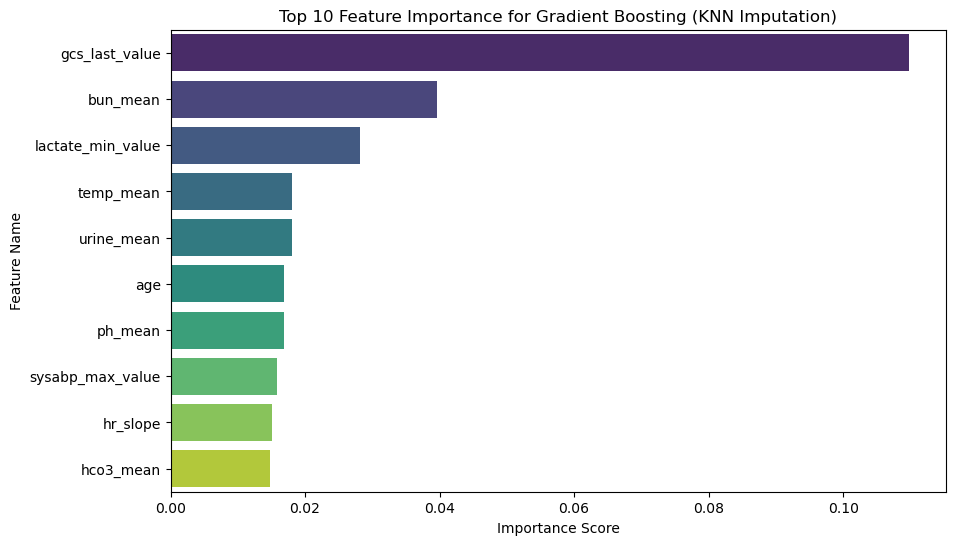


Top 10 Features for XGBoost (KNN Imputation):
['gcs_last_value' 'bun_mean' 'albumin_mean' 'icutype' 'urine_max_value'
 'paco2_mean' 'temp_last_value' 'lactate_min_value' 'urine_mean'
 'gcs_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


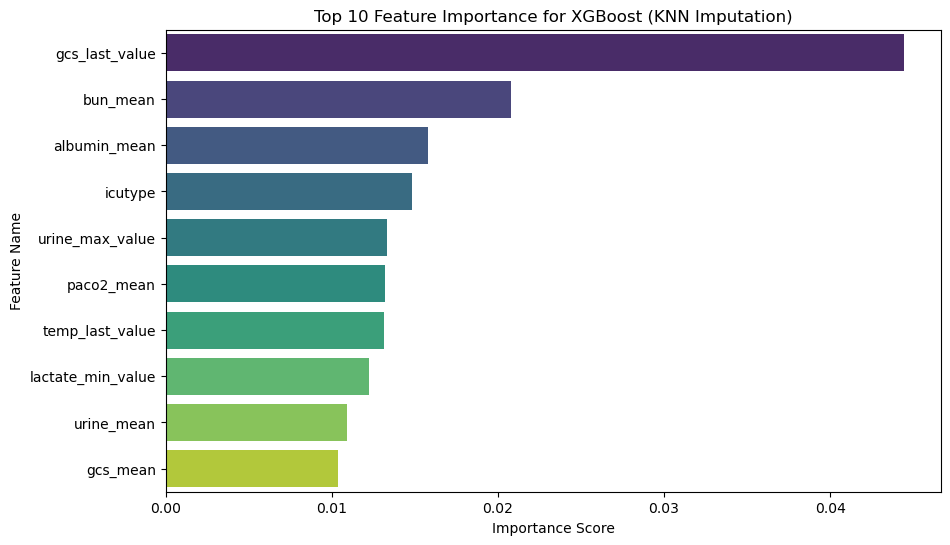


Top 10 Features for Random Forest (Iterative Imputation):
['gcs_last_value' 'bun_mean' 'gcs_mean' 'gcs_max_value' 'urine_mean'
 'gcs_slope' 'paco2_mean' 'alp_mean' 'urine_max_value'
 'lactate_last_value']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


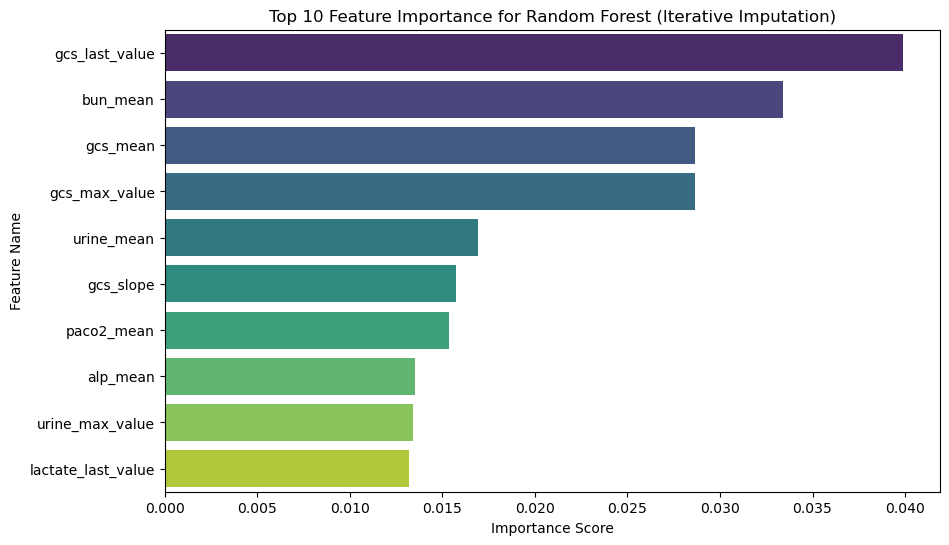


Top 10 Features for Decision Tree (Iterative Imputation):
['gcs_last_value' 'bun_mean' 'albumin_mean' 'urine_mean' 'fio2_median'
 'lactate_last_value' 'lactate_min_value' 'icutype' 'wbc_last_value'
 'glucose_slope']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


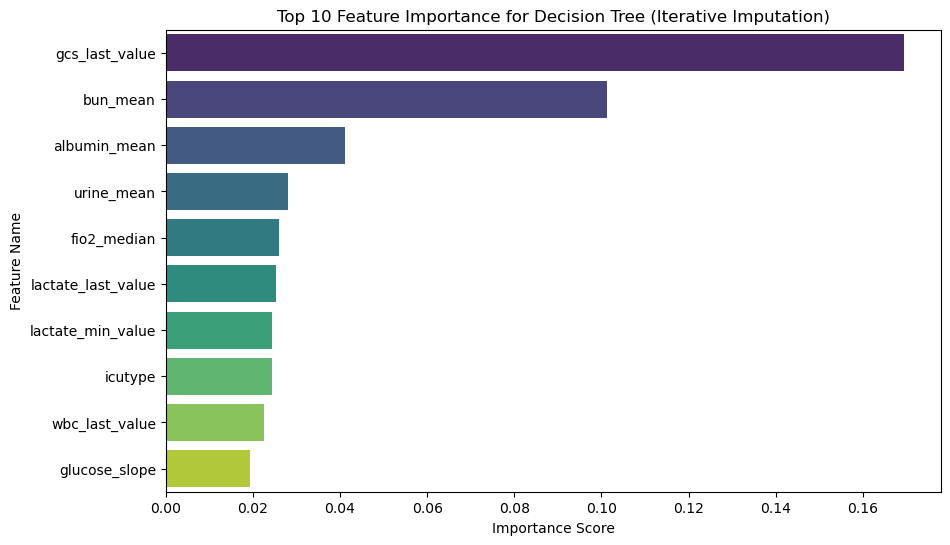


Top 10 Features for Extra Trees (Iterative Imputation):
['gcs_last_value' 'gcs_max_value' 'gcs_mean' 'bun_mean' 'gcs_min_value'
 'icutype' 'urine_max_value' 'age' 'gcs_slope' 'urine_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


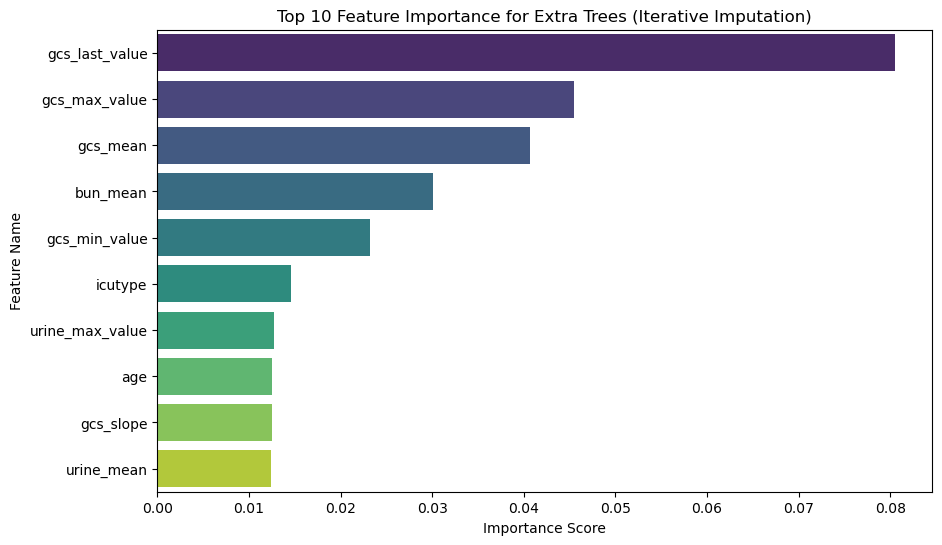


Top 10 Features for Gradient Boosting (Iterative Imputation):
['gcs_last_value' 'bun_mean' 'lactate_min_value' 'urine_mean' 'temp_mean'
 'age' 'glucose_last_value' 'lactate_last_value' 'ph_mean'
 'sysabp_last_value']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


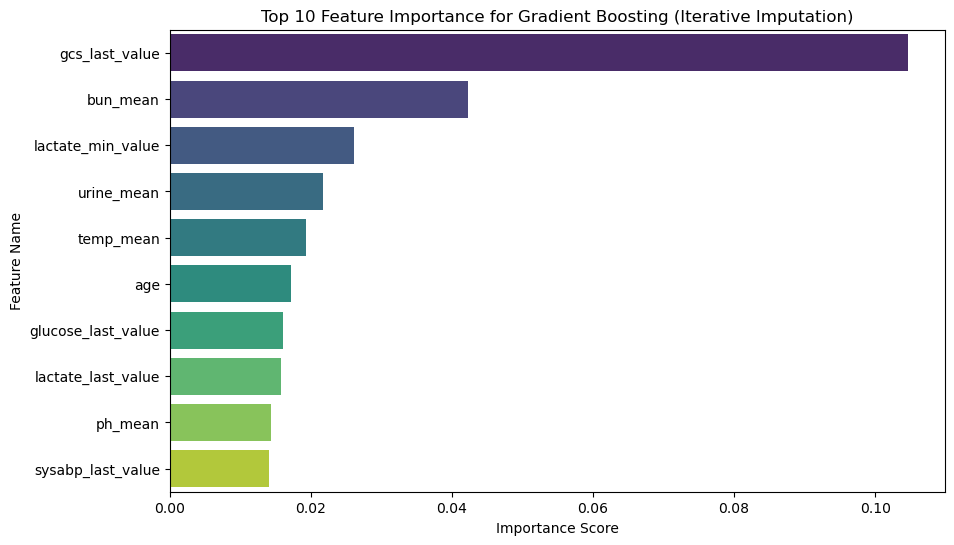


Top 10 Features for XGBoost (Iterative Imputation):
['gcs_last_value' 'bun_mean' 'fio2_median' 'icutype' 'urine_max_value'
 'temp_last_value' 'gcs_mean' 'albumin_mean' 'fio2_last_value'
 'paco2_mean']


/home/samanseifi/codes/projects/moratility_rate_prediction_1/model_evaluator_adjusted.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


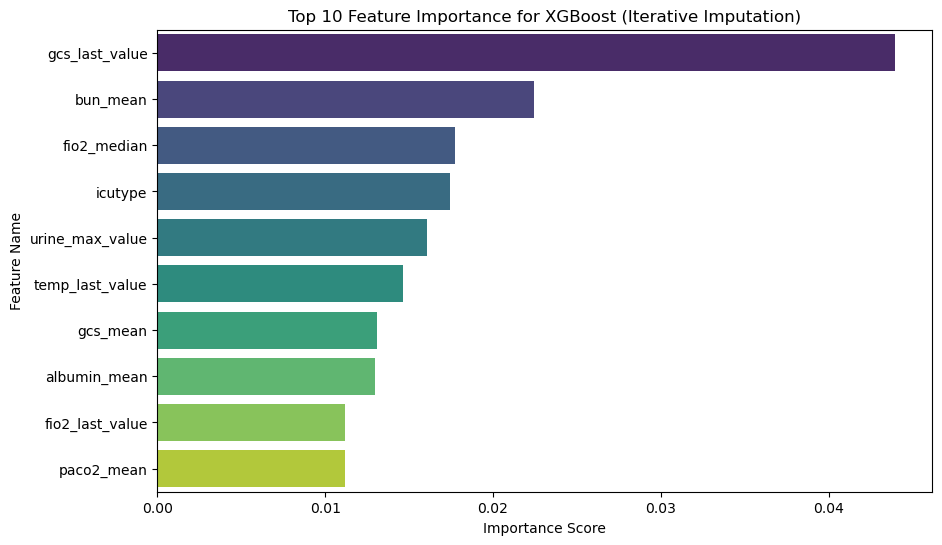

In [5]:
feature_visualizer = FeatureImportanceVisualizer(evaluator.feature_importance_data, 10)
feature_visualizer.run()